In [3]:
import os
import sys
import cv2
import torch
import numpy as np
import imageio
import glob
import matplotlib.pyplot as plt
import imageio.v3 as iio
import kornia
import kornia.geometry as KG
import json
import open3d as o3d

import kornia.geometry.depth as depth

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# **White Mask**

In [ ]:
# Define input and output directories
input_folder = "D:\IndependentStudy\dataset_test\Stata\inputs\images"  # Folder with RGB images
output_folder = "D:\IndependentStudy\dataset_test\Stata\inputs\pmasks"  # Folder to save white masks

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Process all image files
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(input_folder, filename)

        # Read the image to get dimensions
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping {filename}: Unable to read file.")
            continue

        height, width = img.shape[:2]  # Get image dimensions

        # Create a completely white mask (255)
        mask = np.full((height, width), 255, dtype=np.uint8)

        # Save mask with the same filename
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask_path = os.path.join(output_folder, mask_filename)
        cv2.imwrite(mask_path, mask)

        print(f"Mask created: {mask_filename} (Size: {width}x{height})")

print("Mask generation complete!")

# **JPG to PNG**

In [ ]:
# Define input and output directories
input_folder = "D:\IndependentStudy\Relightable3DGaussian-main\datasets\data_tnt\Backyard\inputs\images"   # Replace with your JPG folder path
output_folder = "D:\IndependentStudy\Relightable3DGaussian-main\datasets\data_tnt\Backyard\inputs\imagespng"  # Replace with your output folder path

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Loop through all JPG images
for filename in os.listdir(input_folder):
    if filename.lower().endswith(".jpg"):
        # Read the image
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Skipping {filename}: Unable to read file")
            continue
        
        # Convert filename to .png
        new_filename = os.path.splitext(filename)[0] + ".png"
        output_path = os.path.join(output_folder, new_filename)

        # Save as PNG
        cv2.imwrite(output_path, img)
        print(f"Converted: {filename} -> {new_filename}")

print("Conversion complete!")


# **Correct the intrinsics by times 2**

In [ ]:
def process_camera_file(file_path):
    """Multiply fx, fy, cx, cy by 2 in intrinsic matrix of camera.txt files."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Locate the start of intrinsic matrix
    try:
        intrinsic_start = lines.index("intrinsic\n") + 1
    except ValueError:
        print(f"Skipping {file_path}: 'intrinsic' keyword not found.")
        return

    if intrinsic_start + 2 > len(lines):
        print(f"Skipping {file_path}: Intrinsic matrix is incomplete.")
        return

    # First row (fx, cx)
    values = list(map(float, lines[intrinsic_start].split()))
    if len(values) >= 3:
        values[0] *= 2  # fx
        values[2] *= 2  # cx
    lines[intrinsic_start] = " ".join(map(str, values)) + "\n"

    # Second row (fy, cy)
    values = list(map(float, lines[intrinsic_start + 1].split()))
    if len(values) >= 3:
        values[1] *= 2  # fy
        values[2] *= 2  # cy
    lines[intrinsic_start + 1] = " ".join(map(str, values)) + "\n"

    # Save back to the file
    with open(file_path, 'w') as f:
        f.writelines(lines)

    print(f"Updated: {file_path}")

def main(directory):
    """Find and process all .txt files in the given directory."""
    camera_files = glob.glob(os.path.join(directory, "*.txt"))

    if not camera_files:
        print("No camera.txt files found. Check your directory path.")
        return

    for file in camera_files:
        process_camera_file(file)

# Set directory path
input_dir = "C:/Users/Biru/Desktop/Statanew/inputs/cams"  # Change this if needed

# Run the script
main(input_dir)


# **Depth to Normal**

In [ ]:
import os
import sys
import numpy as np
import imageio.v3 as iio
import cv2
import torch
from kornia.geometry.depth import depth_to_normals

# --- Save PFM ---
def write_pfm(file, image, scale=-1.0):
    with open(file, "wb") as f:
        if image.dtype.name != "float32":
            raise Exception("Image dtype must be float32.")
        image = np.flipud(image)
        f.write(b"PF\n" if image.shape[2] == 3 else b"Pf\n")
        f.write(f"{image.shape[1]} {image.shape[0]}\n".encode())
        f.write(f"{scale}\n".encode())
        image.tofile(f)

# --- Load intrinsics from text file ---
def load_camera_intrinsics(cam_file):
    with open(cam_file, "r") as f:
        lines = f.readlines()
    try:
        intrinsic_start = lines.index("intrinsic\n") + 1
    except ValueError:
        raise ValueError(f"Could not find 'intrinsic' in {cam_file}!")
    K = np.array([
        list(map(float, lines[intrinsic_start].split())),
        list(map(float, lines[intrinsic_start + 1].split())),
        list(map(float, lines[intrinsic_start + 2].split()))
    ], dtype=np.float32)
    return torch.tensor(K, dtype=torch.float32).unsqueeze(0)  # (1, 3, 3)

# --- Paths ---
depth_dir = r"C:/Users/Biru/Desktop/Statanew/inputs/depths"
cam_dir = r"C:/Users/Biru/Desktop/Statanew/inputs/cams"
output_dir = r"C:/Users/Biru/Desktop/Statanew/inputs/normals"

os.makedirs(output_dir, exist_ok=True)

depth_files = sorted([f for f in os.listdir(depth_dir) if f.endswith(".tiff")])
cam_files = sorted([f for f in os.listdir(cam_dir) if f.endswith(".txt")])

if len(depth_files) != len(cam_files):
    print("Depth and camera file count mismatch!")
    sys.exit(1)

# --- Process each pair ---
for depth_file, cam_file in zip(depth_files, cam_files):
    depth_path = os.path.join(depth_dir, depth_file)
    cam_path = os.path.join(cam_dir, cam_file)

    print(f"Processing {depth_file} with {cam_file}...")

    # Load depth
    depth_np = iio.imread(depth_path).astype(np.float32)
    depth_np[np.isnan(depth_np) | np.isinf(depth_np)] = 0  # remove invalid floats

    # Convert to tensor
    depth_tensor = torch.from_numpy(depth_np.copy()).unsqueeze(0).unsqueeze(0).float()  # (1,1,H,W)

    # Load intrinsics
    K = load_camera_intrinsics(cam_path)

    # Compute normal map using Kornia
    with torch.no_grad():
        normal_map = depth_to_normals(depth_tensor, K, normalize_points=False)  # (1,3,H,W)
    normal_np = normal_map.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (H,W,3)

    # Mask invalid normals from invalid depth
    invalid_mask = (depth_np <= 0)
    normal_np[invalid_mask] = 0.0

    # Save as .pfm
    out_path = os.path.join(output_dir, f"{os.path.splitext(depth_file)[0]}.pfm")
    write_pfm(out_path, normal_np)
    print(f"✅ Saved normal map: {out_path}")

print("🎉 Done: all normals generated (no inpainting).")



# **Visualize normal map**

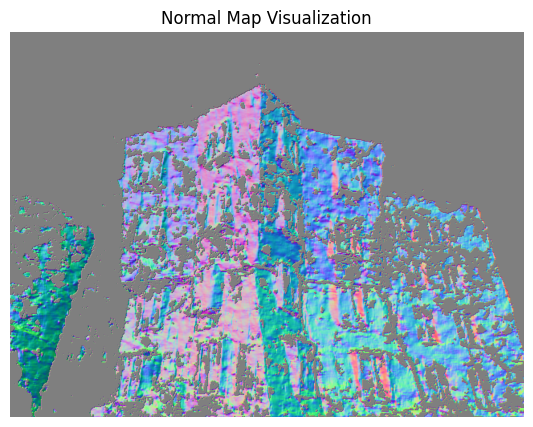

In [9]:
# Function to read a PFM file
def read_pfm(file):
    with open(file, "rb") as f:
        header = f.readline().decode().strip()
        if header == "PF":
            color = True
        elif header == "Pf":
            color = False
        else:
            raise ValueError("Not a PFM file.")

        dimensions = f.readline().decode().strip()
        width, height = map(int, dimensions.split())

        scale = float(f.readline().decode().strip())
        if scale < 0:  # Little-endian
            endian = "<"
            scale = -scale
        else:
            endian = ">"

        data = np.fromfile(f, endian + "f")

    # Reshape to (H, W, 3) for color or (H, W) for grayscale
    shape = (height, width, 3) if color else (height, width)
    return np.flipud(data.reshape(shape)), scale

# Path to the PFM file
# pfm_file = "D:/IndependentStudy/Relightable3DGaussian-main/datasets/data_tnt/Barn/inputs/normals/00000001.pfm"
# pfm_file = "C:/Users/Biru/Desktop/Barn/00000001_normal_noblack.pfm"
pfm_file = "C:/Users/Biru/Desktop/Statam/Statam/inputs/normals/00000041.pfm"  # Change this to your PFM file path
# Load and visualize
normal_map, scale = read_pfm(pfm_file)

# Normalize from [-1,1] to [0,1] for visualization
normalized_map = (normal_map + 1) / 2

# Show the normal map
plt.figure(figsize=(10, 5))
plt.imshow(normalized_map)
plt.axis("off")
plt.title("Normal Map Visualization")
plt.show()


# **Visualize depth map**

Auto Contrast Scaling: vmin=4.153846740722656, vmax=9.901782035827637


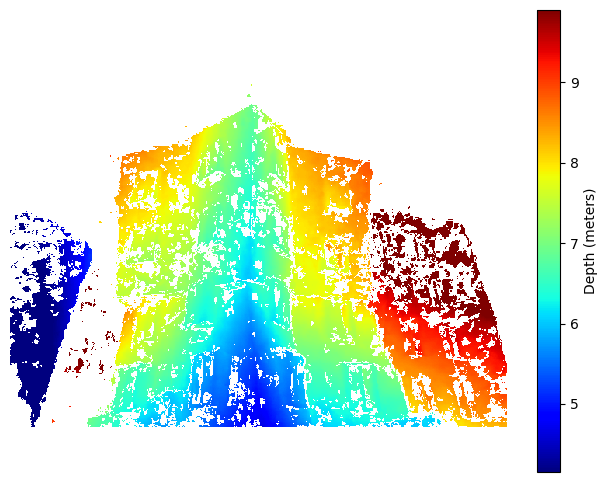

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

def visualize_depth_auto(file):
    depth = iio.imread(file).astype(np.float32)

    # Replace zeros with NaN (optional)
    depth[depth == 0] = np.nan

    # Compute valid min/max (ignoring NaN)
    vmin, vmax = np.nanpercentile(depth, [5, 95])  # Use percentiles instead of min/max

    print(f"Auto Contrast Scaling: vmin={vmin}, vmax={vmax}")

    # Display depth map
    plt.figure(figsize=(8, 6))
    im = plt.imshow(depth, cmap="jet", interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Depth (meters)")
    plt.axis("off")
    plt.show()

# Test with your file
visualize_depth_auto("C:/Users/Biru/Desktop/Statam/Statam/inputs/depths/00000041.tiff")



In [71]:
import numpy as np
import imageio.v3 as iio

depth = iio.imread("D:/IndependentStudy/Relightable3DGaussian-main/datasets/data_tnt/Barn/inputs/depths/00000000.tiff").astype(np.float32)

# Print depth statistics
print(f"Min Depth: {np.nanmin(depth)}, Max Depth: {np.nanmax(depth)}")
print(f"Mean Depth: {np.nanmean(depth)}, Std Dev: {np.nanstd(depth)}")

# Count invalid values
num_zero = np.sum(depth == 0)
num_nan = np.sum(np.isnan(depth))

print(f"Zero Depth Pixels: {num_zero}, NaN Pixels: {num_nan}")


Min Depth: 0.0, Max Depth: 2.393681049346924
Mean Depth: 0.30889108777046204, Std Dev: 0.41906774044036865
Zero Depth Pixels: 1247380, NaN Pixels: 0


# **Visualize depth range**

📂 File: /content/drive/MyDrive/Thesis/datasets/depth/00000000.tiff
🔹 Min Depth: 0.00
🔹 Max Depth: 22.86
🟢 Likely Unit: meters (m)


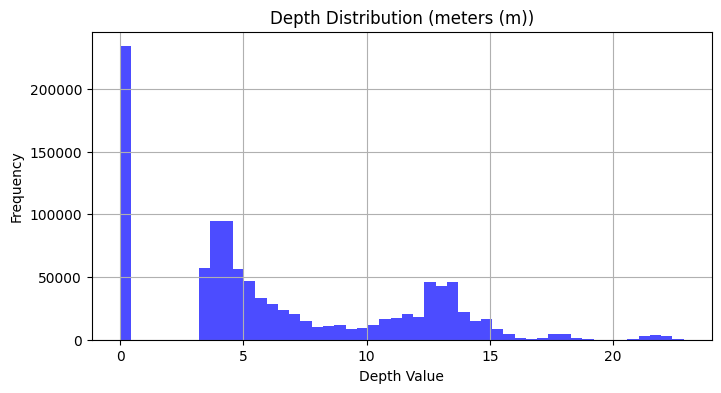

In [ ]:
def check_depth_units(depth_path):
    """Check whether a TIFF depth map is in millimeters or meters."""

    # Load the depth map
    depth = iio.imread(depth_path).astype(np.float32)

    # Compute min and max values
    min_depth = np.min(depth)
    max_depth = np.max(depth)

    # Determine unit
    if max_depth > 10_000:
        unit = "millimeters (mm)"
    elif max_depth < 1000:
        unit = "meters (m)"
    else:
        unit = "⚠️ Unknown (Check Manually)"

    # Print results
    print(f"📂 File: {depth_path}")
    print(f"🔹 Min Depth: {min_depth:.2f}")
    print(f"🔹 Max Depth: {max_depth:.2f}")
    print(f"🟢 Likely Unit: {unit}")

    # Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(depth.flatten(), bins=50, color='blue', alpha=0.7)
    plt.xlabel("Depth Value")
    plt.ylabel("Frequency")
    plt.title(f"Depth Distribution ({unit})")
    plt.grid(True)
    plt.show()

# Example usage
depth_file = "/content/drive/MyDrive/Thesis/datasets/depth/00000000.tiff"  # Change to your file path
check_depth_units(depth_file)


# **Scene JSON**

In [13]:
# Define paths
data_root = r"C:/Users/Biru/Desktop/Statanew"
image_dir = r"C:/Users/Biru/Desktop/Statanew/inputs/images"
camera_dir = os.path.join(data_root,"inputs", "cams")
points3D_file = os.path.join(data_root, "sparse_col", "points3D.txt")
output_json = os.path.normpath(os.path.join(data_root, "inputs", "sfm_scene.json"))

# Ensure output directory exists
os.makedirs(os.path.dirname(output_json), exist_ok=True)

# Function to load intrinsics from a camera file
def load_intrinsics(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    intrinsic_start = lines.index("intrinsic\n") + 1
    K = np.array([
        list(map(float, lines[intrinsic_start].split())),
        list(map(float, lines[intrinsic_start + 1].split())),
        list(map(float, lines[intrinsic_start + 2].split()))
    ])
    return {
        "ppt": [K[0][2], K[1][2]],  # cx, cy
        "focal": [K[0][0], K[1][1]]  # fx, fy
    }

# Function to load extrinsics from a camera file
def load_extrinsics(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    extrinsic_start = lines.index("extrinsic\n") + 1
    E = np.array([
        list(map(float, lines[extrinsic_start].split())),
        list(map(float, lines[extrinsic_start + 1].split())),
        list(map(float, lines[extrinsic_start + 2].split())),
        list(map(float, lines[extrinsic_start + 3].split()))
    ])
    return E.flatten().tolist()  # Store as a flat list for JSON

# Function to compute the bounding box from points3D.txt
def compute_bbox_from_points3D(txt_file):
    """Compute bounding box from points3D.txt file."""
    points = []
    with open(txt_file, 'r') as f:
        for line in f:
            if line.startswith("#") or line.strip() == "":
                continue  # Skip comments and empty lines
            values = line.split()
            x, y, z = map(float, values[1:4])  # Extract X, Y, Z coordinates
            points.append([x, y, z])

    points = np.array(points)
    min_bound = points.min(axis=0)  # (min_x, min_y, min_z)
    max_bound = points.max(axis=0)  # (max_x, max_y, max_z)
    center = (min_bound + max_bound) / 2
    size = max_bound - min_bound

    # Convert to 4x4 transformation matrix
    bbox_transform = np.array([
        [size[0], 0, 0, center[0]],
        [0, size[1], 0, center[1]],
        [0, 0, size[2], center[2]],
        [0, 0, 0, 1]
    ])

    return bbox_transform.flatten().tolist()


def compute_normalized_bbox_transform(txt_file):
    """Compute a uniform scaling + centering transform from points3D.txt."""
    points = []
    with open(txt_file, 'r') as f:
        for line in f:
            if line.startswith("#") or line.strip() == "":
                continue
            values = line.split()
            x, y, z = map(float, values[1:4])  # X, Y, Z
            points.append([x, y, z])

    points = np.array(points)
    min_bound = np.min(points, axis=0)
    max_bound = np.max(points, axis=0)
    center = (min_bound + max_bound) / 2.0

    # Uniform scale: fit longest axis into unit cube [-1, 1]^3
    scale = (max_bound - min_bound).max() / 2.0

    # 4x4 transformation matrix: uniform scale and center
    transform = np.array([
        [1/scale, 0,       0,       -center[0]/scale],
        [0,       1/scale, 0,       -center[1]/scale],
        [0,       0,       1/scale, -center[2]/scale],
        [0,       0,       0,        1]
    ])

    return transform.flatten().tolist()

# def compute_uniform_bbox(txt_file, scale_down=0.1):
#     """Compute a uniform scaling + center-based bbox from points3D.txt"""
#     points = []
#     with open(txt_file, 'r') as f:
#         for line in f:
#             if line.startswith("#") or line.strip() == "":
#                 continue
#             values = line.split()
#             x, y, z = map(float, values[1:4])
#             points.append([x, y, z])

#     points = np.array(points)
#     min_bound = np.min(points, axis=0)
#     max_bound = np.max(points, axis=0)
#     center = (min_bound + max_bound) / 2
#     size = max_bound - min_bound

#     # Uniform scale using the largest dimension
#     max_size = np.max(size)
#     uniform_scale = max_size * scale_down

#     # Build uniform bbox transform
#     bbox_transform = np.array([
#         [uniform_scale, 0, 0, center[0]],
#         [0, uniform_scale, 0, center[1]],
#         [0, 0, uniform_scale, center[2]],
#         [0, 0, 0, 1]
#     ])

#     return bbox_transform.flatten().tolist()

# def compute_uniform_bbox(txt_file, scale_factor=0.5):
#     """
#     Compute a uniform 4x4 bounding box transform matrix from points3D.txt.
#     Keeps full shape but scales compactly using a uniform scale factor.
#     """
#     points = []
#     with open(txt_file, 'r') as f:
#         for line in f:
#             if line.startswith("#") or line.strip() == "":
#                 continue
#             x, y, z = map(float, line.split()[1:4])
#             points.append([x, y, z])

#     points = np.array(points)
#     min_bound = points.min(axis=0)
#     max_bound = points.max(axis=0)
#     center = (min_bound + max_bound) / 2
#     size = max_bound - min_bound
#     max_extent = np.max(size)

#     # Uniform scale based on extent
#     uniform_scale = max_extent * scale_factor

#     # Build the 4x4 transformation matrix
#     bbox_transform = np.array([
#         [uniform_scale, 0, 0, center[0]],
#         [0, uniform_scale, 0, center[1]],
#         [0, 0, uniform_scale, center[2]],
#         [0, 0, 0, 1]
#     ])

#     print("Bounding box center:", center)
#     print("Max extent:", max_extent)
#     print("Uniform scale applied:", uniform_scale)

#     return bbox_transform.flatten().tolist()

def compute_uniform_bbox(txt_file, target_extent=1.0):
    points = []
    with open(txt_file, 'r') as f:
        for line in f:
            if line.startswith("#") or line.strip() == "":
                continue
            x, y, z = map(float, line.split()[1:4])
            points.append([x, y, z])

    points = np.array(points)
    min_bound = points.min(axis=0)
    max_bound = points.max(axis=0)
    center = (min_bound + max_bound) / 2.0
    size = max_bound - min_bound
    max_extent = np.max(size)

    # Scale to target_extent box (e.g., 0.1, 1.0)
    scale = target_extent / max_extent

    print(f"Center: {center}")
    print(f"Original size: {size}")
    print(f"Max extent: {max_extent}")
    print(f"Scale applied: {scale}")

    bbox_transform = np.array([
        [scale, 0, 0, center[0]],
        [0, scale, 0, center[1]],
        [0, 0, scale, center[2]],
        [0, 0, 0, 1]
    ])

    return bbox_transform.flatten().tolist()

# def compute_final_rectangular_bbox(txt_file, scale_factor=1.0, padding_ratio=0.05):
#     """
#     Compute a proper axis-aligned rectangular bbox for GS.
#     Returns only the 4x4 bbox["transform"] list.
#     """
#     points = []
#     with open(txt_file, 'r') as f:
#         for line in f:
#             if line.startswith("#") or line.strip() == "":
#                 continue
#             x, y, z = map(float, line.split()[1:4])
#             points.append([x, y, z])
#     points = np.array(points)

#     min_bound = points.min(axis=0)
#     max_bound = points.max(axis=0)
#     center = (min_bound + max_bound) / 2
#     size = max_bound - min_bound
#     padded_size = size * (1 + 2 * padding_ratio)
#     scaled_size = padded_size * scale_factor

#     # Create the axis-aligned rectangular bbox transform (not uniform)
#     bbox_transform = [
#         scaled_size[0], 0.0, 0.0, center[0],
#         0.0, scaled_size[1], 0.0, center[1],
#         0.0, 0.0, scaled_size[2], center[2],
#         0.0, 0.0, 0.0, 1.0
#     ]

#     return bbox_transform


# Compute bounding box
bbox_transform = compute_bbox_from_points3D(points3D_file)

# Collect all camera files and image files
camera_files = sorted([f for f in os.listdir(camera_dir) if f.endswith(".txt")])
image_files = sorted(os.listdir(image_dir))

# Build scene JSON structure
sfm_scene = {    
    "image_path": { "file_paths": {str(i): os.path.join("images", img).replace("\\", "/") for i, img in enumerate(image_files)}},
    "bbox": {"transform": bbox_transform},
    "camera_track_map": {"images": {}}
}

# Process each camera file
for cam_file in camera_files:
    cam_path = os.path.join(camera_dir, cam_file)

    # Extract index from filename (e.g., 00000000_cam.txt → 00000000)
    index = int(cam_file.split("_")[1])  # Extract image index

    # Match with image filename (Assumes image filenames also follow 00000000.jpg)
    img_filename = f"{index:08d}.jpg"  # Adjust for your image format (e.g., .png)
    img_path = os.path.join(image_dir, img_filename)


    # Extract image resolution dynamically
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping...")
        continue
    height, width = img.shape[:2]

    # Load intrinsics & extrinsics
    K = load_intrinsics(cam_path)
    E = load_extrinsics(cam_path)

    # Store in JSON format with actual image size
    sfm_scene["camera_track_map"]["images"][str(index)] = {
        "flg": 2,  # Valid camera
        "size": [width, height],  # Dynamically determined size
        "camera": {
            "intrinsic": K,
            "extrinsic": E
        }
    }

# Save JSON file
with open(output_json, 'w') as f:
    json.dump(sfm_scene, f, indent=4)

print(f"`sfm_scene.json` saved at: {output_json}")


`sfm_scene.json` saved at: C:\Users\Biru\Desktop\Statanew\inputs\sfm_scene.json


# **JPG to PNG**

In [ ]:
import os
import cv2
from pathlib import Path

def convert_images_to_png(input_folder, output_folder):
    """
    Converts all images in a folder to PNG format and saves them in the output folder.

    Args:
        input_folder (str): Path to the folder containing input images.
        output_folder (str): Path to the folder where PNG images will be saved.
    """
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Supported image formats
    valid_extensions = (".jpg", ".jpeg", ".bmp", ".tiff", ".tif", ".webp")

    for img_file in Path(input_folder).glob("*"):
        if img_file.suffix.lower() in valid_extensions:
            # Read image
            img = cv2.imread(str(img_file))
            if img is None:
                print(f"Skipping {img_file}, could not read.")
                continue

            # Save as PNG
            output_path = os.path.join(output_folder, img_file.stem + ".png")
            cv2.imwrite(output_path, img)
            print(f"Converted: {img_file} → {output_path}")

# Example usage
input_folder = "/content/drive/MyDrive/Thesis/datasets/image"  # Change this to your folder
output_folder = "/content/drive/MyDrive/Thesis/datasets/image"
convert_images_to_png(input_folder, output_folder)


In [16]:
def parse_colmap_points(file_path):
    """
    Reads COLMAP points3D.txt and extracts 3D coordinates.
    """
    points = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        if line.startswith("#") or not line.strip():
            continue
        data = line.strip().split()
        x, y, z = map(float, data[1:4])  # Extract X, Y, Z
        points.append([x, y, z])
    
    return np.array(points)

def compute_bounding_box(points3D):
    """
    Compute the bounding box transformation matrix.
    """
    min_xyz = np.min(points3D, axis=0)
    max_xyz = np.max(points3D, axis=0)
    center = (min_xyz + max_xyz) / 2  # Bounding box center
    scale = max_xyz - min_xyz  # Size of the bounding box
    
    # Construct transformation matrix
    T = np.eye(4)
    T[0, 0] = scale[0]  # Scale in X
    T[1, 1] = scale[1]  # Scale in Y
    T[2, 2] = scale[2]  # Scale in Z
    T[:3, 3] = center  # Translation to center
    
    return T

# Path to your points3D.txt file
file_path = r"C:\Users\Biru\Desktop\n\colmap\sparse\points3D.txt"

# Load 3D points from COLMAP
points3D = parse_colmap_points(file_path)

# Compute bounding box transform
bbox_transform = compute_bounding_box(points3D)

# Save as JSON
bbox_json = {
    "bbox": {
        "transform": bbox_transform.flatten().tolist()
    }
}

print(bbox_json)


{'bbox': {'transform': [69.5418252118266, 0.0, 0.0, 15.766708064739456, 0.0, 59.33897148714733, 0.0, 10.44965061625111, 0.0, 0.0, 112.73417187123161, 9.286479859391054, 0.0, 0.0, 0.0, 1.0]}}


In [6]:
def parse_colmap_points(file_path):
    """
    Reads COLMAP points3D.txt and extracts 3D coordinates.
    """
    points = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        if line.startswith("#") or not line.strip():
            continue
        data = line.strip().split()
        x, y, z = map(float, data[1:4])  # Extract X, Y, Z
        points.append([x, y, z])
    
    return np.array(points)

def compute_bounding_box(points3D):
    """
    Compute the bounding box transformation matrix in the required format.
    """
    min_xyz = np.min(points3D, axis=0)
    max_xyz = np.max(points3D, axis=0)
    
    center = (min_xyz + max_xyz) / 2  # Bounding box center
    scale = max_xyz - min_xyz  # Full size of the bounding box
    
    # Construct the transformation matrix
    T = np.eye(4)
    T[0, 0] = scale[0]  # Scale in X
    T[1, 1] = scale[1]  # Scale in Y
    T[2, 2] = scale[2]  # Scale in Z
    T[0, 3] = center[0]  # Center X
    T[1, 3] = center[1]  # Center Y
    T[2, 3] = center[2]  # Center Z

    return T.flatten().tolist()

# Path to your points3D.txt file
file_path = r"C:\Users\Biru\Desktop\n\colmap\sparse\points3D.txt"

# Load 3D points from COLMAP
points3D = parse_colmap_points(file_path)

# Compute bounding box transform in correct format
bbox_transform = compute_bounding_box(points3D)

# Save as JSON in the required format
bbox_json = {
    "bbox": {
        "transform": bbox_transform
    }
}

print(bbox_json)


{'bbox': {'transform': [69.5418252118266, 0.0, 0.0, 15.766708064739456, 0.0, 59.33897148714733, 0.0, 10.44965061625111, 0.0, 0.0, 112.73417187123161, 9.286479859391054, 0.0, 0.0, 0.0, 1.0]}}


In [29]:
bbox_transform = np.array([
    [69.5418252118266, 0, 0, 15.766708064739456],
    [0, 59.33897148714733, 0, 10.44965061625111],
    [0, 0, 112.73417187123161, 9.286479859391054],
    [0, 0, 0, 1]
])  # Replace with your actual BBox

def scale_bbox(bbox_transform, scale_factor=0.1):
    """ Scale the bounding box while keeping the center at (0,0,0). """
    bbox_transform[:3, :3] *= scale_factor  # Scale the X, Y, Z dimensions
    return bbox_transform

# Example: Scale BBox down to half its size
scaled_bbox = scale_bbox(bbox_transform, scale_factor=0.5)
print("Scaled BBox:\n", scaled_bbox)

Scaled BBox:
 [[34.77091261  0.          0.         15.76670806]
 [ 0.         29.66948574  0.         10.44965062]
 [ 0.          0.         56.36708594  9.28647986]
 [ 0.          0.          0.          1.        ]]


In [ ]:
import numpy as np
from plyfile import PlyData, PlyElement

def read_points3D_txt(file_path):
    xyzs = []
    rgbs = []
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.strip().split()
            x, y, z = map(float, parts[1:4])
            r, g, b = map(int, parts[4:7])
            xyzs.append([x, y, z])
            rgbs.append([r, g, b])
    return np.array(xyzs, dtype=np.float32), np.array(rgbs, dtype=np.uint8)

def write_ply(path, xyz, rgb, normals=None):
    if normals is None:
        normals = np.random.randn(*xyz.shape).astype(np.float32)
        normals /= np.linalg.norm(normals, axis=1, keepdims=True)

    data = np.empty(xyz.shape[0], dtype=[
        ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
        ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4'),
        ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')
    ])
    data['x'], data['y'], data['z'] = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    data['nx'], data['ny'], data['nz'] = normals[:, 0], normals[:, 1], normals[:, 2]
    data['red'], data['green'], data['blue'] = rgb[:, 0], rgb[:, 1], rgb[:, 2]

    el = PlyElement.describe(data, 'vertex')
    PlyData([el], text=True).write(path)
    print(f"✅ Wrote: {path}")


# Change these paths as needed
input_txt = "C:/Users/Biru/Desktop/Barn/sparse_col/points3D.txt"
output_ply = "C:/Users/Biru/Desktop/Barn/sparse.ply"

xyz, rgb = read_points3D_txt(input_txt)
write_ply(output_ply, xyz, rgb)


In [15]:
import os
import shutil

# Path to the root directory containing all the pano folders
root_dir = r"E:/Drone_Data/0428_Stata"
# Path to the destination folder where all renamed images will be moved
destination_dir = r'E:/Drone_Data/0428_Stata/processed'

os.makedirs(destination_dir, exist_ok=True)

# Iterate through all subfolders in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):
        image_files = sorted([
            f for f in os.listdir(folder_path)
            if f.lower().endswith('.jpg')
        ])
        for image_file in image_files:
            src_path = os.path.join(folder_path, image_file)

            # Correct way to extract number from filename
            base_name = os.path.splitext(image_file)[0]  # 'PANO0008'
            number_part = base_name.replace('PANO', '')  # '0008'

            # Create new filename
            new_filename = f"{number_part}_{folder_name}.jpg"
            dst_path = os.path.join(destination_dir, new_filename)

            shutil.move(src_path, dst_path)
            print(f"Moved: {src_path} → {dst_path}")


Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0001.JPG → E:/Drone_Data/0428_Stata/processed\0001_102_0191.jpg
Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0002.JPG → E:/Drone_Data/0428_Stata/processed\0002_102_0191.jpg
Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0003.JPG → E:/Drone_Data/0428_Stata/processed\0003_102_0191.jpg
Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0004.JPG → E:/Drone_Data/0428_Stata/processed\0004_102_0191.jpg
Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0005.JPG → E:/Drone_Data/0428_Stata/processed\0005_102_0191.jpg
Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0006.JPG → E:/Drone_Data/0428_Stata/processed\0006_102_0191.jpg
Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0007.JPG → E:/Drone_Data/0428_Stata/processed\0007_102_0191.jpg
Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0008.JPG → E:/Drone_Data/0428_Stata/processed\0008_102_0191.jpg
Moved: E:/Drone_Data/0428_Stata\102_0191\PANO0009.JPG → E:/Drone_Data/0428_Stata/processed\0009_102_0191.jpg
Moved: E:/Drone_Dat

In [ ]:
import os
import random
import shutil

# Folder containing the images
source_dir = r"E:/Stata_0425"
# Folder to copy selected images into
destination_dir = r'E:/Stata_0425/Stata_0425_processed'

# Create the destination folder if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Get list of all .jpg images in the folder
all_images = [f for f in os.listdir(source_dir) if f.lower().endswith('.jpg')]

# Randomly sample 400 images
selected_images = random.sample(all_images, min(400, len(all_images)))

# Copy selected images to destination
for img_name in selected_images:
    src_path = os.path.join(source_dir, img_name)
    dst_path = os.path.join(destination_dir, img_name)
    shutil.copy(src_path, dst_path)
    print(f"Copied: {src_path} → {dst_path}")


Copied: C:/Users/Biru/Desktop/Stata/images\0009_101_0969.jpg → C:/Users/Biru/Desktop/Stata/selected_images\0009_101_0969.jpg
Copied: C:/Users/Biru/Desktop/Stata/images\0005_102_0047.jpg → C:/Users/Biru/Desktop/Stata/selected_images\0005_102_0047.jpg
Copied: C:/Users/Biru/Desktop/Stata/images\0003_102_0054.jpg → C:/Users/Biru/Desktop/Stata/selected_images\0003_102_0054.jpg
Copied: C:/Users/Biru/Desktop/Stata/images\0006_101_0933.jpg → C:/Users/Biru/Desktop/Stata/selected_images\0006_101_0933.jpg
Copied: C:/Users/Biru/Desktop/Stata/images\0007_102_0002.jpg → C:/Users/Biru/Desktop/Stata/selected_images\0007_102_0002.jpg
Copied: C:/Users/Biru/Desktop/Stata/images\0005_101_0972.jpg → C:/Users/Biru/Desktop/Stata/selected_images\0005_101_0972.jpg
Copied: C:/Users/Biru/Desktop/Stata/images\0004_101_0996.jpg → C:/Users/Biru/Desktop/Stata/selected_images\0004_101_0996.jpg
Copied: C:/Users/Biru/Desktop/Stata/images\0004_102_0019.jpg → C:/Users/Biru/Desktop/Stata/selected_images\0004_102_0019.jpg


In [2]:
import os
from PIL import Image

# Input and output folder paths
input_dir = r'C:/Users/Biru/Desktop/Stata/input'
output_dir = r'C:/Users/Biru/Desktop/Stata/input_resized'
os.makedirs(output_dir, exist_ok=True)

# Loop through all .jpg files in the folder
for filename in os.listdir(input_dir):
    if filename.lower().endswith('.jpg'):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        # Open and resize image
        with Image.open(input_path) as img:
            resized_img = img.resize(
                (img.width // 2, img.height // 2),
                Image.LANCZOS  # high-quality downsampling filter
            )
            resized_img.save(output_path)
            print(f"Resized and saved: {output_path}")


Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0191_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0192_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0193_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0194_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0195_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0196_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0197_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0198_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0199_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0200_processed.jpg
Resized and saved: C:/Users/Biru/Desktop/Stata/input_resized\0001_102_0201_processed.jpg
Resized and saved: C:

In [3]:
from PIL import Image
import os

# Input and output directories
input_dir = r'C:/Users/Biru/Desktop/Stata/input'
output_dir = r'C:/Users/Biru/Desktop/Stata/input_resized'
os.makedirs(output_dir, exist_ok=True)

# Target size
target_size = (1280, 960)

# Supported image formats
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Resize images
for filename in os.listdir(input_dir):
    if filename.lower().endswith(valid_extensions):
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)
        img_resized = img.resize(target_size, Image.LANCZOS)  # High-quality downsampling
        save_path = os.path.join(output_dir, filename)
        img_resized.save(save_path)
        print(f"Resized and saved: {filename}")

print("Done resizing all images to 1280×960.")


Resized and saved: 0001_102_0191_processed.jpg
Resized and saved: 0001_102_0192_processed.jpg
Resized and saved: 0001_102_0193_processed.jpg
Resized and saved: 0001_102_0194_processed.jpg
Resized and saved: 0001_102_0195_processed.jpg
Resized and saved: 0001_102_0196_processed.jpg
Resized and saved: 0001_102_0197_processed.jpg
Resized and saved: 0001_102_0198_processed.jpg
Resized and saved: 0001_102_0199_processed.jpg
Resized and saved: 0001_102_0200_processed.jpg
Resized and saved: 0001_102_0201_processed.jpg
Resized and saved: 0001_102_0202_processed.jpg
Resized and saved: 0001_102_0203_processed.jpg
Resized and saved: 0001_102_0204_processed.jpg
Resized and saved: 0001_102_0205_processed.jpg
Resized and saved: 0001_102_0206_processed.jpg
Resized and saved: 0001_102_0207_processed.jpg
Resized and saved: 0001_102_0208_processed.jpg
Resized and saved: 0001_102_0209_processed.jpg
Resized and saved: 0001_102_0210_processed.jpg
Resized and saved: 0001_102_0211_processed.jpg
Resized and s

# **Generate Masks** 

In [3]:
# Input/output paths
mask_dir = r"C:\Users\Biru\Desktop\Stata\inputs\masks\SegmentationClass"
output_dir = r"C:\Users\Biru\Desktop\Stata\inputs\binary_masks"
os.makedirs(output_dir, exist_ok=True)

# Define expected color values
PURPLE = [192, 128, 192]
BLACK = [0, 0, 0]

# Target size for full white masks (adjust if needed)
default_size = (960, 1280)  # height, width

# Loop over image indices
for i in range(221):  # from 00000000 to 00000220
    filename = f"{i:08d}.png"
    mask_path = os.path.join(mask_dir, filename)
    output_path = os.path.join(output_dir, filename)

    if os.path.exists(mask_path):
        # Load mask
        mask_bgr = cv2.imread(mask_path)
        mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)

        # Create mask where black → white, purple → black
        binary_mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)

        # Where original is black → set to white
        is_black = np.all(mask_rgb == BLACK, axis=-1)
        binary_mask[is_black] = 255

        # Purple remains black (0), nothing else is handled

        # Save
        cv2.imwrite(output_path, binary_mask)
    else:
        # No mask: create full white mask
        height, width = default_size
        binary_mask = np.ones((height, width), dtype=np.uint8) * 255
        cv2.imwrite(output_path, binary_mask)

    print(f"Processed: {filename}")

print("✅ All binary masks generated.")


Processed: 00000000.png
Processed: 00000001.png
Processed: 00000002.png
Processed: 00000003.png
Processed: 00000004.png
Processed: 00000005.png
Processed: 00000006.png
Processed: 00000007.png
Processed: 00000008.png
Processed: 00000009.png
Processed: 00000010.png
Processed: 00000011.png
Processed: 00000012.png
Processed: 00000013.png
Processed: 00000014.png
Processed: 00000015.png
Processed: 00000016.png
Processed: 00000017.png
Processed: 00000018.png
Processed: 00000019.png
Processed: 00000020.png
Processed: 00000021.png
Processed: 00000022.png
Processed: 00000023.png
Processed: 00000024.png
Processed: 00000025.png
Processed: 00000026.png
Processed: 00000027.png
Processed: 00000028.png
Processed: 00000029.png
Processed: 00000030.png
Processed: 00000031.png
Processed: 00000032.png
Processed: 00000033.png
Processed: 00000034.png
Processed: 00000035.png
Processed: 00000036.png
Processed: 00000037.png
Processed: 00000038.png
Processed: 00000039.png
Processed: 00000040.png
Processed: 00000